# Normalizing flow

In this notebook, we will create our own normalizing flow model, and
train it to reproduce the “moons” distribution available from the
`sklearn` library.

We will use affine coupling layers to compose our normalizing flow.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from math import pi


## The data

First, let’s visualise the data that we want to be able to reproduce
with a normalizing flow.

In [2]:
n_samples = 1_000
data, _ = make_moons(n_samples=n_samples, noise=0.05)
data.shape

(1000, 2)

The data is composed of 2 columns (i.e., random variables). We can
visualize the data using a scatter plot.

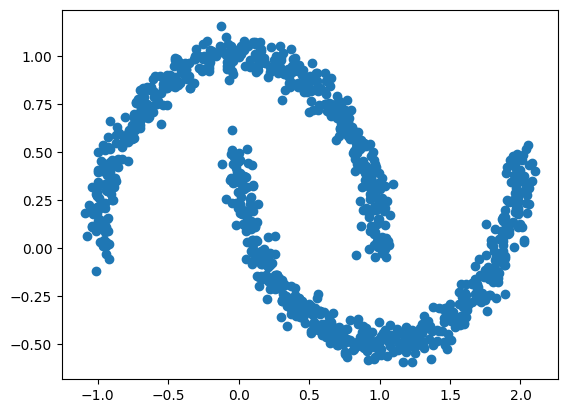

In [3]:
fig=plt.scatter(data[:,0], data[:,1])

## The model

The whole normalizing flow model is composed of multiple coupling
layers. So that we avoid code duplication, we will first define our own
affine coupling layer, which we will later on reuse when composing our
normalizing flow.

### Affine coupling layer

And affine coupling layer need to be able to do the following steps:

1.  Split the input variables (`x`) into 2 parts - one that stays the
    same (`x1`), and one that is being transformed (`x2`).
2.  Use `x1` to “predict” the shift (`mu`) and scale (`sigma`) of the
    affine transform of `x2`
3.  Compute the transformation of `x2`: `x2 = mu + sigma * x2`
4.  Concatenate `x1` and the transformed `x2`

In [4]:
class AffineCoupling(keras.layers.Layer):
    def __init__(self, swap, n_units, n_layers):
        """ This is where we initiate the layer
        Parameters
        ----------
        swap: bool
            Whether or not to swap x1 and x2
        n_units: int
            How many neurons should each layer of our coupling network be
        n_layers: int
            How many layers should the coupling network be
        """
        super(AffineCoupling, self).__init__()

    
        self.swap = swap

        # Create two networs: one for scale and one for shift 
        self.sigma = keras.Sequential(
            [keras.layers.Dense(n_units, activation="gelu") for _ in range(n_layers)]
            )
        # scale should be always positive, so the ouptut activation is softplus
        self.sigma.add(keras.layers.Dense(1, activation="softplus"))

        self.mu = keras.Sequential(
            [keras.layers.Dense(n_units, activation="gelu") for _ in range(n_layers)]
            )
        self.mu.add(keras.layers.Dense(1))
        

    def call(self, x, backward=False):
        """ Call the coupling layer
        
        1. Split the data in two halfs
        2. Compute the scale and shift parameters based on one half (x1)
        3. Scale and shift the other half (x2)
        4. Concatenate x1 and x2

        Parameters
        ----------
        x: Tensor
            The input data
        backward: bool
            Should we do a backward (inverse) transform instead?
        """
        if self.swap:
            x2, x1 = keras.ops.split(x, indices_or_sections=2, axis=1)
        else:
            x1, x2 = keras.ops.split(x, indices_or_sections=2, axis=1)
            
        sigma = self.sigma(x1)
        mu = self.mu(x1)

        if backward:
            y2 = x2 * sigma + mu
            log_det_jac = keras.ops.log(sigma)
        else:
            y2 = (x2 - mu) / sigma
            log_det_jac = -keras.ops.log(sigma)

        if self.swap:
            y = keras.ops.concatenate([y2, x1], axis=1)
        else:
            y = keras.ops.concatenate([x1, y2], axis=1)

        return y, log_det_jac

### Normalizing flow

The whole normalizing flow model needs to hold a collection of coupling
layers, and alternate between which axis will get transformed. When data
are passed in, the network should call the layers sequentially.

We will implement

-   `.forward` method (data -\> base distribution)
-   `.backward` method (base distribution -\> data)
-   `.log_prob` method that we will use for training
-   `.sample` method that simply samples from the base distribution and
    calls the `.backward` method to produce samples from the data
    distribution

The base distribution we chose is Normal, which makes our coupling
affine model a Normalizing flow.

In [5]:
class NormalizingFlow(keras.Model):
    def __init__(self, n_coupling_layers, n_units, n_layers):
        """ Initialize the normalizing flow model

        Parameters
        ----------
        n_coupling_layers: int
            How many coupling layers does the model consist of
        n_units: int
            How many neurons should each layer of our coupling layers be
        n_layers: int
            How many layers should the coupling network be
        """
        super(NormalizingFlow, self).__init__()
        self.coupling_layers = [AffineCoupling(swap=(i % 2 == 0), n_units=n_units, n_layers=n_layers) for i in range(n_coupling_layers)]

    def forward(self, x):
        """Run the normalizing flow in forward direction (data -> base)
        """
        log_det_jac = keras.ops.zeros(x[...,:1].shape)

        z = x
        for layer in self.coupling_layers:
            z, ldj = layer(z)
            log_det_jac = log_det_jac + ldj

        return z, log_det_jac

    def backward(self, z):
        """Run the normalizing flow in the backward direction (base -> data)
        """
        log_det_jac = keras.ops.zeros(z[...,:1].shape)

        x = z
        for layer in reversed(self.coupling_layers):
            x, ldj = layer(x, backward=True)
            log_det_jac = log_det_jac + ldj
        
        return x, log_det_jac

    def log_prob(self, x):
        """Calculate the log probability of the data"""
        z, log_det_jac = self.forward(x)
        log_prob = self.log_prob_base(z) + log_det_jac

        return log_prob

    def log_prob_base(self, z):
        """Helper method: Calculate the (unnormalized) density of a bivariate normal base distribution"""
        kernel = -0.5 * keras.ops.sum(z ** 2, axis=-1)
        
        return kernel

    def sample(self, n_samples):
        """Sample from the data distribution"""
        z = keras.random.normal((n_samples, 2))
        x, _ = self.backward(z)

        return x



One we defined our model classes, we can instantiate a new normalizing
flow object.

In [6]:
#flow = NormalizingFlow(n_coupling_layers=10, n_units=16, n_layers=4)
flow = NormalizingFlow(n_coupling_layers=8, n_units=16, n_layers=4)

For example, you can use the object to forward transform our data
samples and plot the results. Because the networks were not trained yet,
the results will not be sensible.

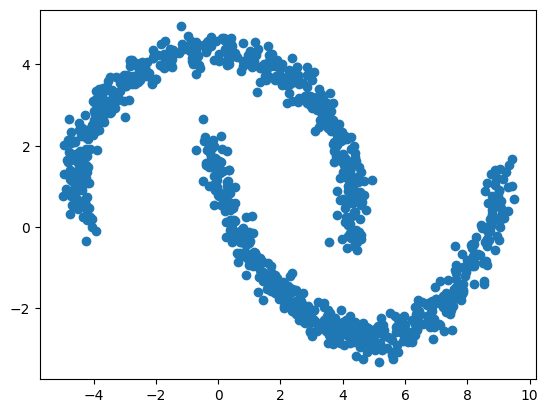

In [7]:
z, _ = flow.forward(data)
fig=plt.scatter(z[:,0], z[:,1])

## Training

We will use manual training loop for training the normalizing flow
model. This should make you see a little bit how the networks are
trained.

To do this, we will need to define our training schedule, our training
data, and, of course, run our training loop.

First, we will need to define our optimizer. Here we will use Adam and
use a CosineDecay learning rate schedule to smoothen the training
process a little.

We will train for a number of epochs. In each epoch, we loop over the
entire dataset in batches. For example, if we have 1_000 data samples
and we make batches of size 50 samples, we will make 15 steps per epoch.
We repeat this for each epoch which will determine the total number of
steps. This calculation is important to make sure that the CosineDecay
schedule is setup correctly.

In [8]:
epochs=100
batch_size=50
schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=epochs * n_samples // batch_size)
optimizer = keras.optimizers.Adam(schedule, global_clipnorm=1.0)

For training, we will use the data that we generated earlier, but we
will chop it into separate batches.

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(data.astype("float64"))
dataset = dataset.batch(batch_size)

To train the model manually, we will need to implement a function that
calculates the gradient of the model weights, given the data. Luckily,
`tensorflow` helps us here by providing a `tf.GradientTape`, which you
can think of as an environment which allows you to automatically
calculate the gradients of a custom loss function with respect to the
trainable weights provided by the model.

Here, our loss function is the negative log-likelihood (implemented by
our normalizing flow model), and we average it over multiple samples
from the data.

In [10]:
def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = - model.log_prob(x)
        loss = tf.reduce_mean(loss)
    
    g = tape.gradient(loss, model.trainable_variables)
    return g, loss   

Now it is time to implement our training loop.

We loop over all epochs. Within each epoch, we loop over all our batches
of data. For each batch of data, we compute the loss and the gradient.
We pass the gradients to the optimizer which updates the network
weights. We also save the computed losses and print them so that we can
keep track of the progress.

In [11]:
losses = []
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in dataset:
        g, loss = train_step(flow, batch)
        optimizer.apply_gradients(zip(g, flow.trainable_variables))
        epoch_loss += loss.numpy()
    epoch_loss = epoch_loss / len(dataset)
    losses.append(epoch_loss)
    
    print("epoch: ", epoch+1, "\tloss: ", epoch_loss)


2025-03-21 15:38:32.394318: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

epoch:  1   loss:  4.509119760990143

2025-03-21 15:38:37.239786: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

epoch:  2   loss:  0.4614365412387997
epoch:  3   loss:  0.03589976973598823

2025-03-21 15:38:46.868376: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

epoch:  4   loss:  -0.07153807431459427
epoch:  5   loss:  -0.15452831350266932
epoch:  6   loss:  -0.2195332646369934
epoch:  7   loss:  -0.3066132962703705

2025-03-21 15:39:06.164537: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

epoch:  8   loss:  -0.3086996302008629
epoch:  9   loss:  -0.14708678657189012
epoch:  10  loss:  -0.33719309568405154
epoch:  11  loss:  -0.5016207732260227
epoch:  12  loss:  -0.5299644388258458
epoch:  13  loss:  -0.5786493174731732
epoch:  14  loss:  -0.4788939183577895
epoch:  15  loss:  -0.6630645548924804

2025-03-21 15:39:46.608116: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

epoch:  16  loss:  -0.3813606560230255
epoch:  17  loss:  -0.7215842207893729
epoch:  18  loss:  -0.6046214617788792
epoch:  19  loss:  -0.7788489066064358
epoch:  20  loss:  -0.789466593042016
epoch:  21  loss:  -0.5925373002886772
epoch:  22  loss:  -0.846959587931633
epoch:  23  loss:  0.986885204911232
epoch:  24  loss:  -0.8945280626416207
epoch:  25  loss:  165269.66411226988
epoch:  26  loss:  -0.9101028084754944
epoch:  27  loss:  -0.9852996498346329
epoch:  28  loss:  -0.8124980151653289
epoch:  29  loss:  -0.9974936187267304
epoch:  30  loss:  -0.9628325670957565
epoch:  31  loss:  -0.9999727696180344

2025-03-21 15:41:05.130025: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

epoch:  32  loss:  -1.0431531459093093
epoch:  33  loss:  -1.0677111208438874
epoch:  34  loss:  -0.9242087975144386
epoch:  35  loss:  -0.8699889570474625
epoch:  36  loss:  -1.0687092512845993
epoch:  37  loss:  -1.0548439770936966
epoch:  38  loss:  -0.8766490086913109
epoch:  39  loss:  -0.7317251592874527
epoch:  40  loss:  -1.0792913630604744
epoch:  41  loss:  -1.140863972902298
epoch:  42  loss:  -1.1754374355077744
epoch:  43  loss:  -1.1837623178958894
epoch:  44  loss:  -1.203491023182869
epoch:  45  loss:  -1.2166150778532028
epoch:  46  loss:  -1.22667535841465
epoch:  47  loss:  -1.2414973974227905
epoch:  48  loss:  -1.2488927781581878
epoch:  49  loss:  -1.2652060627937316
epoch:  50  loss:  -1.2690628826618195
epoch:  51  loss:  -1.2715873539447784
epoch:  52  loss:  -1.268251371383667
epoch:  53  loss:  -1.2901792645454406
epoch:  54  loss:  -1.291833186149597
epoch:  55  loss:  -1.2950453579425811
epoch:  56  loss:  -1.301222288608551
epoch:  57  loss:  -1.3077153325

2025-03-21 15:43:39.859420: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

epoch:  64  loss:  -1.3384576618671418
epoch:  65  loss:  -1.3418648838996887
epoch:  66  loss:  -1.3449950575828553
epoch:  67  loss:  -1.347951352596283
epoch:  68  loss:  -1.3507327556610107
epoch:  69  loss:  -1.3533526301383971
epoch:  70  loss:  -1.3557960271835328
epoch:  71  loss:  -1.3580805480480194
epoch:  72  loss:  -1.3602263271808623
epoch:  73  loss:  -1.3622412204742431
epoch:  74  loss:  -1.3641252756118774
epoch:  75  loss:  -1.3658817768096925
epoch:  76  loss:  -1.3675154507160188
epoch:  77  loss:  -1.3690306961536407
epoch:  78  loss:  -1.370433324575424
epoch:  79  loss:  -1.371729701757431
epoch:  80  loss:  -1.372925877571106
epoch:  81  loss:  -1.3740281283855438
epoch:  82  loss:  -1.3750418305397034
epoch:  83  loss:  -1.3759720921516418
epoch:  84  loss:  -1.376823902130127
epoch:  85  loss:  -1.3776013851165771
epoch:  86  loss:  -1.3783084511756898
epoch:  87  loss:  -1.378948837518692
epoch:  88  loss:  -1.3795257031917572
epoch:  89  loss:  -1.380043011

The losses should decrease over epochs and slowly converge to some
minimum. To see how that better, we can plot the losses.

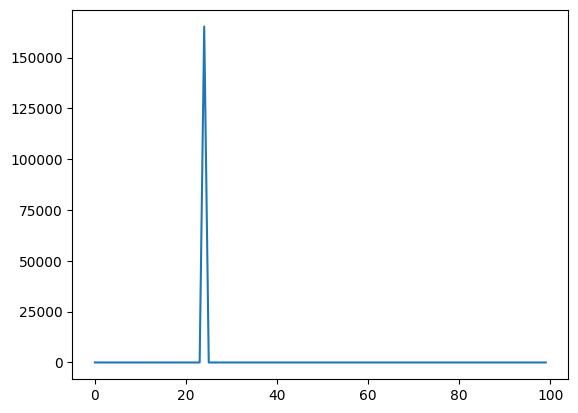

In [12]:
fig=plt.plot(losses)

Now, if we apply the network to the data, the transformed variables
should look much more like sampled from a bivariate normal distribution.

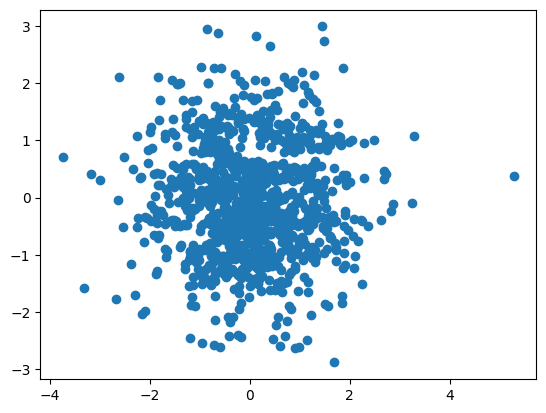

In [13]:
z, _ = flow.forward(data)
fig=plt.scatter(z[:,0], z[:,1])

And conversely we can sample a new data set from the approximate *moons*
distribution using the trained model.

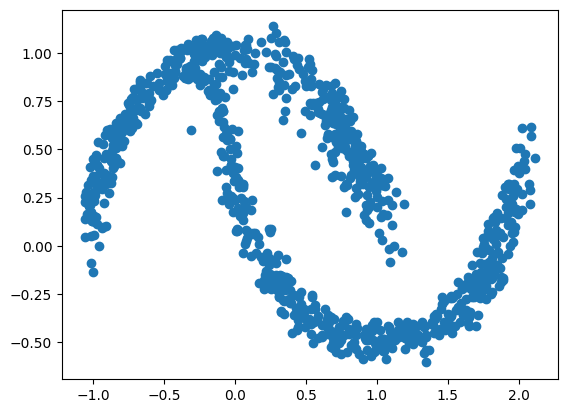

In [14]:
y = flow.sample(n_samples)
fig = plt.scatter(y[:,0], y[:,1])